# still in experiment phase-  not working

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## settings

In [2]:
base_model_class = keras.applications.MobileNetV2
base_model_preprocess_function = keras.applications.mobilenet_v2.preprocess_input

#base_model_class = keras.applications.InceptionV3
#base_model_preprocess_function = keras.applications.inception_v3.preprocess_input

image_size = (128, 128)
input_shape = (image_size[0], image_size[1], 3)
batch_size = 32

## train data preparation
dataset is from : https://www.kaggle.com/koryakinp/fingers

In [3]:


# must be one folder per class inside the directory (is not the case in zip from kaggle) 
train_ds = keras.preprocessing.image_dataset_from_directory(
    "../temp/fingers/train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "../temp/fingers/test",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 18000 files belonging to 6 classes.
Using 14400 files for training.
Found 3600 files belonging to 6 classes.
Using 720 files for validation.


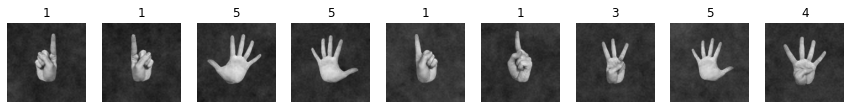

In [4]:
plt.figure(figsize=(15, 2))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(1, 9, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## define the model

In [7]:
base_model = base_model_class(
    input_shape=input_shape, 
    include_top=False,  
    weights="imagenet")
base_model.trainable=False

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(
    input_shape=input_shape))
model.add(keras.layers.Lambda(
    base_model_preprocess_function, 
    name='preprocessing', 
    input_shape=input_shape))
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(
            units=128, 
            name='hidden',
            activation='relu'),)
model.add(keras.layers.Dropout(
    name='dropout',
    rate=0.4))
model.add(keras.layers.Dense(
    len(train_ds.class_names), 
    name='predictions', 
    activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
hidden (Dense)               (None, 128)               2621568   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 6)                 774       
Total params: 4,880,326
Trainable params: 2,622,342
Non-trainable params: 2,257,984
____________________________________

## training of model

In [8]:
epochs = 10
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
#with tf.device('/device:GPU:0'):
history = model.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds,
    batch_size=batch_size,
  )

Epoch 1/10
450/450 [==============================] - 182s 405ms/step - loss: 0.1298 - accuracy: 0.9798 - val_loss: 0.0036 - val_accuracy: 0.9986
Epoch 2/10
450/450 [==============================] - 167s 372ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 6.5529e-05 - val_accuracy: 1.0000
Epoch 3/10
450/450 [==============================] - 164s 364ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0289 - val_accuracy: 0.9944
Epoch 4/10
450/450 [==============================] - 164s 364ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 1.1894e-06 - val_accuracy: 1.0000
Epoch 5/10
450/450 [==============================] - 164s 365ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 2.2684e-06 - val_accuracy: 1.0000
Epoch 6/10
450/450 [==============================] - 170s 377ms/step - loss: 0.0135 - accuracy: 0.9965 - val_loss: 0.0016 - val_accuracy: 0.9986
Epoch 7/10
450/450 [==============================] - 171s 379ms/step - loss: 0.0209 - accuracy: 0.9947 - val_lo

In [ ]:
model.save(f'../models/model_fingers_{base_model_class.__name__}')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/model_fingers_MobileNetV2/assets
